In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Symptom2Disease/Symptom2Disease.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
! pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
! pip install wordcloud
from wordcloud import WordCloud

In [ ]:
data = pd.read_csv(path)

In [ ]:
data.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [ ]:
data['label'].value_counts()

Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: label, dtype: int64

In [ ]:
len(data['label'].value_counts())

24

In [ ]:
data['text'][0]

'I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'

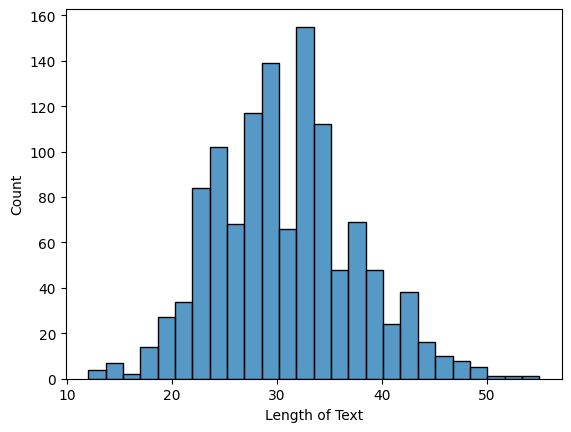

In [ ]:
# check the length of text
text_length = data['text'].apply(lambda x: len(x.split(' ')))

sns.histplot(text_length)
plt.xlabel('Length of Text')
plt.show()

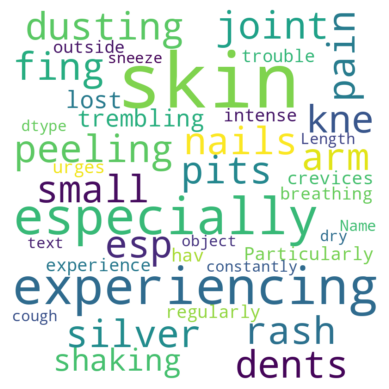

In [ ]:
# wordcloud of symptom texts

stop_words = set(stopwords.words('english'))
# add some stop words
stop_words.update(["I've", "I'm", "like"])

wordcloud = WordCloud(width = 800,
                      height = 800,
                      background_color ='white',
                      stopwords=stop_words,
                      min_font_size = 8).generate(str(data['text']))

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def label_encode(labels):
  label_encoder = LabelEncoder()
  label_encoder.fit(labels)
  label_sequences = label_encoder.transform(labels)
  return label_sequences

In [ ]:
data['label_encoded'] = label_encode(data['label'])

In [ ]:
train_ratio = 0.70
# sample 80% of the data for training and 20% for validation for each label

train = data.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=69))
val = data.drop(train.index)

train_texts = train['text'].values
train_labels = train['label_encoded'].values
val_texts = val['text'].values
val_labels = val['label_encoded'].values

train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape

((840,), (840,), (360,), (360,))

In [ ]:
def remove_stopwords(texts):
  words = [re.split(r'[ ,.]+', text) for text in texts]
  words = [[word.lower() for word in text if word != ''] for text in words]
  stop_words = set(stopwords.words('english'))
  words = [[word for word in text if word.lower() not in stop_words] for text in words]
  return words

In [ ]:
print(train_texts[0])
# test the function
print(remove_stopwords(train_texts)[0])

I've been having a very unhealthy rash on my skin latterly. It's filled with pus-filled pimples and blackheads. My skin has additionally been scurring heaps.
["i've", 'unhealthy', 'rash', 'skin', 'latterly', 'filled', 'pus-filled', 'pimples', 'blackheads', 'skin', 'additionally', 'scurring', 'heaps']


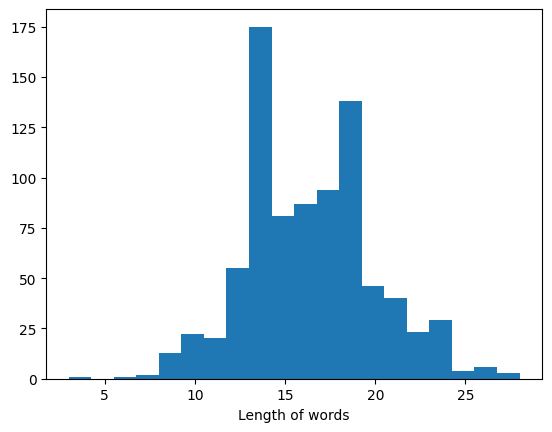

In [ ]:
words_length = [len(w) for w in remove_stopwords(train_texts)]
plt.hist(words_length, bins=20)
plt.xlabel('Length of words')
plt.show()

In [ ]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words,tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
tokenize_and_pad(train_texts, tokenizer)[0]

array([  8,   6,  33,   5,  60, 995,  49,  22,   3,  16, 996,  36, 126,
        25, 132, 126,  93,   2, 135,   3,  16,  13,  86,   6, 512, 997,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(val_texts), tokenizer)
val_labels = val_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('val_sequences shape: ', val_sequences.shape)
print('val_labels shape: ', val_labels.shape)

train_sequences shape:  (840, 50)
train_labels shape:  (840, 1)
val_sequences shape:  (360, 50)
val_labels shape:  (360, 1)


In [ ]:
# define a function to visualize the training and validation loss and accuracy
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

max_length = 50

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         256000    
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 24)                792       
                                                                 
Total params: 260920 (1019.22 KB)
Trainable params: 260920 (1019.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
27/27 [==============================] - 3s 90ms/step - loss: 3.173

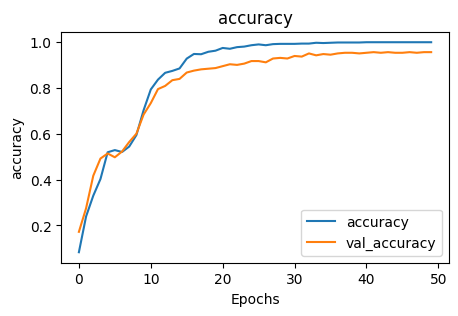

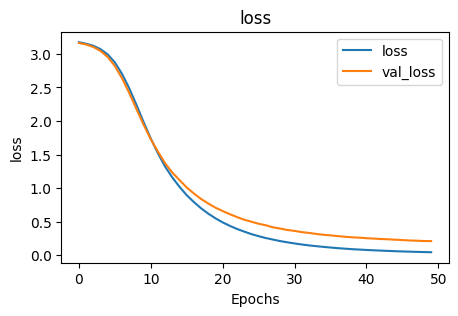

In [ ]:
model_embed = tf.keras.Sequential([
  tf.keras.layers.Embedding(2000, 128),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(24,activation='softmax')
 ])


model_embed.summary()
model_embed.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_embed.fit(train_sequences, train_labels, epochs=50, validation_data=(val_sequences, val_labels))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_embed.evaluate(val_sequences, val_labels)

12/12 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9556


[0.20949269831180573, 0.9555555582046509]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           82048     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                      

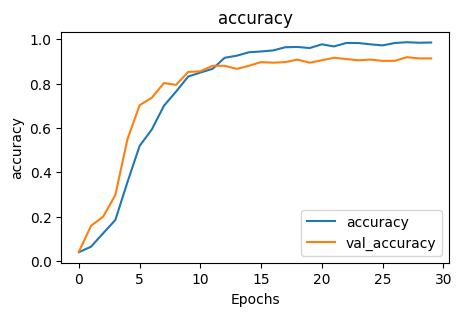

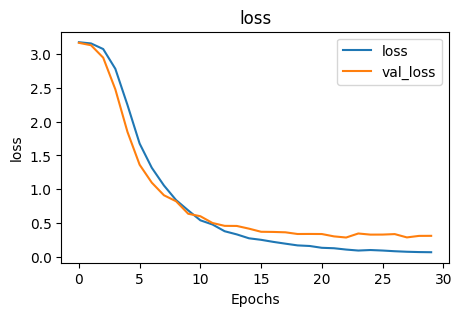

In [ ]:
model_conv = tf.keras.Sequential([
 tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])
model_conv.summary()
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_conv.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_conv.evaluate(val_sequences, val_labels)

12/12 [==============================] - 0s 3ms/step - loss: 0.3069 - accuracy: 0.9139


[0.3069346845149994, 0.9138888716697693]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

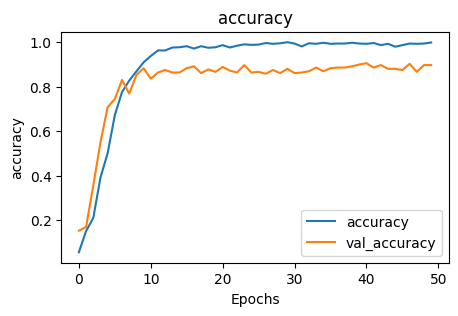

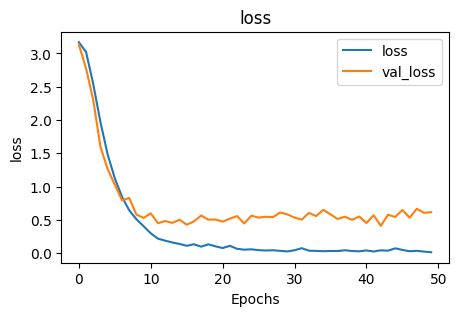

In [ ]:
# build the model with LSTM layer, be careful with overfitting
tf.random.set_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])
model_lstm.summary()

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_lstm.fit(train_sequences, train_labels, epochs=50, validation_data=(val_sequences, val_labels))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# model validation accuracy
model_lstm.evaluate(val_sequences, val_labels)

12/12 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.8972


[0.6153783798217773, 0.8972222208976746]

In [ ]:
# make some text to describe the symptoms

# test_text = ['My skin is dry and itchy. I can see some rashes on my skin and my face turns red easily.']
# test_text = ['My stomach hurts and I feel nauseous. I have diarrhea and I feel weak.']
# test_text = ['red, scaly patches on the skin, itching, dryness, cracking, and bleeding of the skin, swollen and stiff joints, and nail abnormalities.']
test_text = ['The fatigue I have been feeling is extreme and makes it difficult for me to perform even basic tasks. I feel vomitting and developed rashes on my arms, neck and legs.']
# test_text = ["'My muscles have been quite weak, and my neck has been really stiff. My joints have swollen and I've been experiencing a lot of stiffness when I move around. Walking has also been excruciatingly uncomfortable.'"]
print(f"The symptom is: \n {test_text[0]}")

# preprocess the text using the function we defined above
test_sequences = tokenize_and_pad(remove_stopwords(test_text), tokenizer)

# predict the label
test_pred = model_embed.predict(test_sequences)
print(test_pred)
# get the top 3 disease labels with the highest probability
top_3 = np.argsort(test_pred[0])[-3:][::-1]

label_encoder = LabelEncoder().fit(data['label'])
# map the label sequence to the label name
print('The top 3 possible diseases are: ', label_encoder.inverse_transform(top_3))

The symptom is: 
 The fatigue I have been feeling is extreme and makes it difficult for me to perform even basic tasks. I feel vomitting and developed rashes on my arms, neck and legs.
1/1 [==============================] - 0s 48ms/step
[[3.3682227e-06 9.2855373e-07 3.3892715e-07 8.3404401e-04 1.1178723e-02
  5.0600975e-06 9.5483875e-01 3.8882749e-08 4.7070011e-05 4.1457993e-04
  6.5512606e-05 5.2730797e-05 2.7288718e-06 8.1618418e-05 1.9490199e-07
  8.6828358e-03 9.5363421e-04 1.8863491e-05 4.1758834e-04 3.4409943e-05
  1.8092940e-06 6.2873570e-04 4.7318455e-05 2.1689113e-02]]
The top 3 possible diseases are:  ['Dengue' 'urinary tract infection' 'Chicken pox']
